
## 🔧 Setup (required once)

| Variable / field | Purpose | How to provide |
|------------------|---------|----------------|
| **USER_AGENT** | Identifies you in HTTP headers when scraping EDGAR. | Export `USER_AGENT="Ada <ada@example.com>"` before launching Jupyter **or** enter one when the setup cell prompts you. |
| **OPENAI_API_KEY** | Needed for any cell that calls OpenAI. | Export `OPENAI_API_KEY="sk-..."` **or** paste it when prompted in the setup cell. |
    

In [1]:
# ╔════════════════════════════════════════════════════╗
# ║  Setup – supply per-user secrets & identifiers     ║
# ╚════════════════════════════════════════════════════╝
#
# Priority order for both variables
#   1. Environment variable            (best for CI / .env files)
#   2. Interactive prompt via getpass  (input hidden as you type)
#   3. Users can always reassign later in the notebook.
#
import os, sys
from getpass import getpass
from openai import OpenAI

# ---------- USER_AGENT --------------------------------------------
USER_AGENT = os.getenv("USER_AGENT")
if not USER_AGENT:                                # fall back to hidden prompt
    USER_AGENT = getpass(
        "📝  Enter a USER_AGENT for EDGAR "
        '(e.g. "Ada Lovelace <ada@example.com>"): '
    ).strip()
    if not USER_AGENT:
        sys.exit("❌  USER_AGENT is required for EDGAR scraping.")

print("✅ USER_AGENT captured")

# ---------- OPENAI_API_KEY ----------------------------------------
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    try:
        OPENAI_API_KEY = getpass("🔑  Paste your OpenAI API key: ")
    except EOFError:
        sys.exit("❌  OPENAI_API_KEY is required for OpenAI calls.")

# ---------- OpenAI client -----------------------------------------
client_openai = OpenAI(api_key=OPENAI_API_KEY)
print("✅ OpenAI client initialised")


📝  Enter a USER_AGENT for EDGAR (e.g. "Ada Lovelace <ada@example.com>"):  ········


✅ USER_AGENT captured


🔑  Paste your OpenAI API key:  ········


✅ OpenAI client initialised


In [2]:

# ╔════════════════════════════════════════════════════╗
# ║ 1.  Imports                                        ║
# ╚════════════════════════════════════════════════════╝
# ——— standard library ————————————————————————————
import argparse
import datetime as dt
import importlib
import inspect
import json
import os
import pathlib
from pathlib import Path
import random
import re
import time
import uuid

# ——— third-party ————————————————————————————————
import boto3
import numpy as np
import openai
from openai import OpenAI
import pandas as pd
import pytz
import requests
import matplotlib.pyplot as plt

# Allow local helper modules (optional)
sys.path.insert(0, "/tmp")

# ╔════════════════════════════════════════════════════╗
# ║ 2.  Global configuration                           ║
# ╚════════════════════════════════════════════════════╝
RUN_ID   = uuid.uuid4().hex[:8]

# Validator tolerance  (±5 %)
LOWER_TOL_FACTOR = 0.95
UPPER_TOL_FACTOR = 1.05

# OpenAI
completions_model_choice = "gpt-4o"
OPENAI_API_KEY           = os.getenv("OPENAI_API_KEY")  # or Secrets Manager helper

max_tokens_api = 3000
retry_max_api = 50
temperature_api = 0
n_api = 1
sleep_time_lower_bound = 1.00
sleep_time_upper_bound = 1.10
sleep_time = random.uniform(sleep_time_lower_bound, sleep_time_upper_bound)

# Cost model
MIN_WAGE   = 0.50                      # $ / reviewer-minute
MODEL_COST = {"accept": 0.001,
              "reject": 0.001,
              "defer" : 0.001,
              "unresolved": 0.001}

# ── choose where to drop artefacts ────────────────────────────────
OUT_DIR = Path.cwd() / "outputs"          # always visible in UI
OUT_DIR.mkdir(exist_ok=True)              # parents=True not needed here

GT_PATH   = OUT_DIR / "ground_truth.csv"
PASS1_OUT = OUT_DIR / f"ledger_pass1_{RUN_ID}.jsonl"
PASS2_OUT = OUT_DIR / f"ledger_pass2_{RUN_ID}.jsonl"

print("Working directory :", Path.cwd())
print("Artefacts will go :", OUT_DIR)

# Randomised back-off for OpenAI retries
sleep_time = random.uniform(1.00, 1.10)

# ╔════════════════════════════════════════════════════╗
# ║ 3.  AWS / OpenAI clients                           ║
# ╚════════════════════════════════════════════════════╝
s3 = boto3.client("s3")

# ╔════════════════════════════════════════════════════╗
# ║ 4.  Static lookup tables & regex helpers           ║
# ╚════════════════════════════════════════════════════╝
CACHE_DIR  = pathlib.Path(".sec_cache"); CACHE_DIR.mkdir(exist_ok=True)
INPUT_FILE_GROUND_TRUTH = "benchmark_queries_100_FY2021_FY2023.csv"
OUT_FILE_GROUND_TRUTH = OUT_DIR / "ground_truth.csv"

GAAP_MAP = {
    "Revenue": ["Revenues",
                "RevenueFromContractWithCustomerExcludingAssessedTax"],
    "Net Income": ["NetIncomeLoss"],
    "EBITDA": ["EarningsBeforeInterestTaxesDepreciationAmortization"],
    "Operating Income": ["OperatingIncomeLoss"],
    "Total Assets": ["Assets"],
    "EPS (diluted)": ["EarningsPerShareDiluted"],
    "Total Equity": ["StockholdersEquity"],
    "Shares Outstanding (diluted)": ["WeightedAverageNumberOfDilutedSharesOutstanding"],
    "Cash From Operations": ["NetCashProvidedByUsedInOperatingActivities"]
}
CIK_LOOKUP = {
    "AAPL": "0000320193",
    "MSFT": "0000789019",
    "AMZN": "0001018724",
    "NVDA": "0001045810",
    "JPM":  "0000019617",
    "META": "0001326801",
    "GOOGL": "0001652044",
    "BRK.B": "0001067983",
    "KO":   "0000021344",
    "BAC":  "0000070858",
}

IDK_PATTERNS = [
    r"\bdo(?:\s+not|n't)\s+have\s+(?:access|the information)",
    r"\bno\s+.*real[- ]time\s+data",
    r"\bi\s+don't\s+have\s+the\s+specific",
    r"\bnot\s+available\b",
]

UNIT_MULT = {
    "trillion": 1e12, "tn": 1e12, "t": 1e12,
    "billion": 1e9,   "bn": 1e9,  "b": 1e9,
    "million": 1e6,   "mn": 1e6,  "m": 1e6,
    "thousand": 1e3,  "k": 1e3,
    "": 1.0,
}

num_re = re.compile(
    r"""
    (?P<sign>[-+]?)\s*
    (?P<int>(?:\d{1,3}(?:[,\s]\d{3})+|\d+))   # <‑‑ re‑ordered
    (?:\.(?P<frac>\d+))?
    \s*
    (?P<unit>trillion|bn|billion|mn|million|k|thousand|t|m|b)?
    \b
    """,
    re.IGNORECASE | re.VERBOSE,
)

# ╔════════════════════════════════════════════════════╗
# ║ 5.  Pre-allocate ledgers (empty lists)             ║
# ╚════════════════════════════════════════════════════╝
ledger_pass1 = []
ledger_pass2 = []

COLOR_PASS1 = "tab:blue"
COLOR_PASS2 = "tab:orange"


Working directory : /home/ec2-user/SageMaker/notebooks
Artefacts will go : /home/ec2-user/SageMaker/notebooks/outputs


In [3]:

def ask_openai(messages, max_tokens=max_tokens_api, stop=None, retry_max=retry_max_api, model=completions_model_choice):
    """
    Wrapper around OpenAI Chat Completions.

    Parameters
    ----------
    messages : str | list[dict]
        Either a single prompt string or a chat-style list with 'role'/'content'.
    max_tokens : int
        Hard upper-bound on tokens to sample.
    stop : list[str] | None
        Forwarded to OpenAI to stop generation on any of these strings.
    retry_max : int
        Retry count on *any* exception.
    model : str
        Model name to pass through.

    Returns
    -------
    str
        Assistant's raw text reply (stripped of outer quotes).

    Notes
    -----
    * Converts a bare string into `[{"role": "user", "content": ...}]`.
    * Sleeps `sleep_time` seconds between retries (simple linear backoff).
    * Raises `Exception` if still failing after `retry_max` attempts.
    """

    if isinstance(messages, str):  # If the input is just a single string, wrap it in the appropriate structure.
        messages = [{"role": "user", "content": messages}]

    response = None
    retries = 0
    while retries < retry_max:
        try:
            response = client_openai.chat.completions.create(
                model=model,
                messages=messages,
                max_tokens=max_tokens,
                n=1,
                stop=stop,
                temperature=0
            )
            # Assuming the response is a pydantic model, we can access attributes directly
            content = response.choices[0].message.content.strip('"')
            return content
        except Exception as e:  # Catching any exception
            print(f"Error: {e}")
            retries += 1
            if retries >= retry_max:
                raise Exception("API call failed after maximum retries.")
            time.sleep(sleep_time)  # Wait for random seconds before retrying

    raise Exception("Failed to receive a valid response from OpenAI API.")

# ─────────────────────────────────────────────────────────────────────────────
# SEC DOWNLOAD + PARSING HELPERS
# ─────────────────────────────────────────────────────────────────────────────
def sec_companyfacts(cik: str) -> dict:
    """
    Download (or read cached) SEC CompanyFacts JSON for a given CIK.

    * Pads CIK to 10 digits.
    * Caches raw JSON under .sec_cache/CIK##########.json.
    * Sleeps `sleep_time` after a network hit to stay polite.
    """
    cik10 = cik.zfill(10)
    cache = CACHE_DIR / f"{cik10}.json"
    if cache.exists():
        return json.loads(cache.read_text())
    url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{cik10}.json"
    r = requests.get(url, headers={"User-Agent": USER_AGENT}, timeout=20)
    r.raise_for_status()
    cache.write_text(r.text)
    time.sleep(sleep_time)
    return r.json()

def best_10k_item(items: list[dict], fy: int):
    """
    Pick the most authoritative FY record from a list of XBRL facts.

    Priority order
    --------------
    1. Exact FY + form == '10-K'
    2. Exact FY + form == '10-K/A'
    3. If multiple matches, choose the one with the latest 'end' date.
    """
    same_fy = [it for it in items if it.get("fy") == fy]
    # split plain vs amended
    plain   = [it for it in same_fy if it.get("form") == "10-K"]
    amended = [it for it in same_fy if it.get("form") == "10-K/A"]

    def latest(lst):                 # helper returns latest by `end`
        return max(lst, key=lambda d: d.get("end", "0000-00-00"))

    if plain:
        return latest(plain)
    if amended:
        return latest(amended)
    return None


def fy_value(facts: dict, tags: list[str], fy: int):
    """
    Return (value, unit) for a metric in a specific fiscal year.

    Strategy
    --------
    * Strict FY match using `best_10k_item`.
    * If nothing found, fall back to fp=='FY' that ends within calendar year.
    * Prefers '10-K' over '10-K/A'; picks latest end-date among duplicates.
    """
    for tag in tags:
        unit_dict = facts.get("facts", {}).get("us-gaap", {}).get(tag, {}).get("units", {})
        for unit, items in unit_dict.items():
            best = best_10k_item(items, fy)
            if best:
                return best["val"], unit

        # ---------- fallback: match by date span -----------------
        yr_start, yr_end = dt.date(fy, 1, 1), dt.date(fy, 12, 31)
        for unit, items in unit_dict.items():
            fy_items = [
                it for it in items
                if it.get("fp") == "FY"
                and "end" in it
                and yr_start <= dt.date.fromisoformat(it["end"]) <= yr_end
            ]
            if fy_items:
                best = max(fy_items, key=lambda d: d["end"])
                return best["val"], unit
    return None

# ─────────────────────────────────────────────────────────────────────────────
# CSV ENRICHMENT
# ─────────────────────────────────────────────────────────────────────────────
def enrich(csv_path: Path = INPUT_FILE_GROUND_TRUTH) -> None:
    """
    Populate 'answer' and 'unit' columns in the benchmark CSV, in-place.

    * Ensures columns have correct dtypes (float64, string).
    * Pulls CompanyFacts for each unique ticker (cached).
    * Writes the updated CSV back to `csv_path`.
    """
    print(csv_path)
    df = pd.read_csv(csv_path)

    # ensure dtype compatibility before we start writing floats / strings
    df["answer"] = df.get("answer", pd.Series(index=df.index, dtype="float64")).astype("float64")
    df["unit"]   = df.get("unit",   pd.Series(index=df.index, dtype="string")).astype("string")

    # cache SEC JSON once per ticker
    facts_cache = {tkr: sec_companyfacts(CIK_LOOKUP[tkr])
                   for tkr in df["ticker"].unique()}

    for idx, row in df.iterrows():
        tags = GAAP_MAP.get(row["metric"])
        if not tags:
            continue
        res = fy_value(facts_cache[row["ticker"]], tags, int(row["period"]))
        if res:
            val, unit = res
            df.at[idx, "answer"] = val
            df.at[idx, "unit"]   = unit

    df.to_csv(OUT_FILE_GROUND_TRUTH, index=False)
    print(f"✅ wrote {OUT_FILE_GROUND_TRUTH.resolve()}")

# ─────────────────────────────────────────────────────────────────────────────
# NUMERIC EXTRACTION + LLM HELPERS
# ─────────────────────────────────────────────────────────────────────────────
def looks_like_idk(text: str) -> bool:
    """Heuristic: does the draft answer contain an 'I don't know' disclaimer?"""
    return any(re.search(pat, text, re.I) for pat in IDK_PATTERNS)

def parse_numeric(text: str) -> float | None:
    """
    Extract first numeric token + magnitude unit, return value in raw USD.

    * Recognises trillion / billion / million / thousand suffixes.
    * Returns None if pattern or unit missing.
    """
    match = num_re.search(text.replace("$", ""))
    if not match:
        return None

    whole = match.group("int").replace(",", "").replace(" ", "")
    frac  = match.group("frac") or ""
    sign  = -1 if match.group("sign") == "-" else 1
    val   = float(f"{whole}.{frac}") if frac else float(whole)
    unit  = (match.group("unit") or "").lower()

    mult  = UNIT_MULT.get(unit, None)
    if mult is None:
        return None                      # unknown unit string
    return sign * val * mult

# ---------- helpers -----------------------------------
def generator_llm(q: str) -> str:
    """Call `ask_openai` with zero-temperature to produce a draft answer."""
    return ask_openai(
        messages=[{"role": "user", "content": q}]
    )

def referee_llm_det(q: str, draft: str, lo: float, hi: float) -> bool:
    """
    Deterministic validator for numeric queries.

    Workflow
    --------
    1. `looks_like_idk` → 'defer'
    2. `parse_numeric` → 'defer' on failure
    3. Accept if `lo <= value <= hi`, else 'reject'
    """
    if looks_like_idk(draft):
        return "defer"             # new state
    val = parse_numeric(draft)
    #print(f"[REFEREE] Q='{q[:60]}…'  draft='{draft[:60]}…'  parsed_val={val}")
    if val is None:
        return "defer"             # couldn’t extract number
    return "accept" if lo <= val <= hi else "reject"

def judge_external(row, reason):
    """
    Simulated human fallback (External Judge).

    * Always returns authoritative `row.answer`.
    * Adds 60 s latency & 1.0 human_min.
    * `reason` informs provenance tag.
    """
    answer  = row.answer      # authoritative value
    latency = 60              # seconds of expert lookup (simulated)
    provenance = f"fallback:{reason}"
    return answer, 1.0, provenance     # value, human_min, tag

def write_memory(query_hash, answer):
    """
    Persist an accepted answer to precedent store (stub in toy demo).
    """
    # stub for future precedent store
    pass

# ─────────────────────────────────────────────────────────────────────────────
# KPI + PLOTTING
# ─────────────────────────────────────────────────────────────────────────────
def compute_kpi(ledger_path: str, storage_opts=None) -> dict:
    """
    Load a JSONL ledger and compute acceptance / cost metrics.

    Returns
    -------
    dict  keys include:
        accept_rate, reject_rate, defer_rate, coverage_rate,
        avg_latency_s, total_human_min, total_cost_$
    """

    df = pd.read_json(ledger_path, lines=True, storage_options=storage_opts or {})

    # pick the latest state column: state, state_p2, state_p3 ...
    state_cols = sorted([c for c in df.columns if re.match(r"state(_p\d+)?$", c)])
    state_col  = state_cols[-1]

    N  = len(df)
    counts = df[state_col].value_counts()
    accept = (df[state_col] == "accept").sum()
    reject = (df[state_col] == "reject").sum()
    defer  = (df[state_col] == "defer").sum()
    unres  = (df[state_col] == "unresolved").sum() if "unresolved" in df[state_col].values else 0

    # monetise
    df["dollars"] = (
          df[state_col].map(MODEL_COST).fillna(0)
        + df["human_min"] * MIN_WAGE
    )

    return {
        "ledger"          : ledger_path,
        "state_column"    : state_col,
        "total_queries"   : N,
        "accept_rate"     : accept / N,
        "reject_rate"     : reject / N,
        "defer_rate"      : defer  / N,
        "unresolved_rate" : unres  / N,
        "coverage_rate"   : (accept + reject) / N,
        "avg_latency_s"   : df.latency_s.mean(),
        "total_human_min" : df.human_min.sum(),
        "total_cost_$"    : df.dollars.sum(),
    }

def plot_comparison(kpi1: dict, kpi2: dict, out_dir: Path | None = None):
    """
    Side-by-side bar charts:

    * Chart 1 — accept / reject / defer share, coloured consistently.
    * Chart 2 — total \$ cost per pass.

    Saves PNGs to `out_dir` when provided (README-ready).
    """
    label1, label2 = "Pass 1", "Pass 2"      # or kpi1["ledger"].stem, …

    # ── chart 1  (classification mix) ──────────────────────────────
    cats  = ["accept_rate", "reject_rate", "defer_rate"]
    y1    = [kpi1[c] for c in cats]
    y2    = [kpi2[c] for c in cats]
    x     = range(len(cats))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
    ax.bar([xi - width/2 for xi in x], y1, width,
           label=label1, color=COLOR_PASS1)
    ax.bar([xi + width/2 for xi in x], y2, width,
           label=label2, color=COLOR_PASS2)

    ax.set_xticks(x)
    ax.set_xticklabels([c.replace("_rate", "") for c in cats])
    ax.set_ylim(0, 1)
    ax.set_ylabel("fraction")
    ax.set_title("Classifications per pass")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18),
              ncol=2, frameon=False)

    if out_dir:
        fig.savefig(out_dir / "kpi_bar.png", dpi=120, bbox_inches="tight")
    plt.show()

    # ── chart 2  (total $ cost) ───────────────────────────────────
    fig2, ax2 = plt.subplots(figsize=(4, 3), constrained_layout=True)
    ax2.bar(0, kpi1["total_cost_$"], color=COLOR_PASS1, label=label1)
    ax2.bar(1, kpi2["total_cost_$"], color=COLOR_PASS2, label=label2)

    ax2.set_xticks([0, 1])
    ax2.set_xticklabels([label1, label2])
    ax2.set_ylabel("$ total cost")
    ax2.set_title("End-to-end cost")
    ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
               ncol=2, frameon=False)

    if out_dir:
        fig2.savefig(out_dir / "cost_bar.png", dpi=120, bbox_inches="tight")
    plt.show()

# ─── Change in cost / accepted query ───────────────────────────────
def cost_per_accept(kpi: dict) -> float | None:
    """Return $/accept or None if there were zero accepts."""
    n_acc = int(round(kpi["accept_rate"] * kpi["total_queries"]))
    return kpi["total_cost_$"] / n_acc if n_acc else None

def pretty_print_kpi(k: dict) -> None:
    """Readable console dump of key KPI fields + monetised cost."""
    print("\n== KPI Summary ==")
    for key in [
        "total_queries", "accept_rate", "reject_rate", "defer_rate",
        "unresolved_rate", "coverage_rate", "avg_latency_s",
        "total_human_min",
    ]:
        val = k[key]
        print(f"{key:20}: {val:.3f}" if isinstance(val, float) else
              f"{key:20}: {val}")
    print(f"\nEstimated total $ cost: ${k['total_cost_$']:.2f}")


In [4]:

"""
fill_answers_from_sec.py
Populate the 'answer' column of the 100‑query benchmark CSV
using SEC Company Facts data (10‑K).  Tolerates Jupyter's -f flag.
"""

ap = argparse.ArgumentParser()
ap.add_argument("--csv", default=str(INPUT_FILE_GROUND_TRUTH),
                help="Input benchmark CSV (local path).")
args, _rest = ap.parse_known_args()
enrich(Path(args.csv))


benchmark_queries_100_FY2021_FY2023.csv
✅ wrote /home/ec2-user/SageMaker/notebooks/outputs/ground_truth.csv


In [5]:

# ╔══════════════════════════════════════════════════════════════════════╗
# ║ PASS-1  ·  Deterministic “validator” loop                            ║
# ╠──────────────────────────────────────────────────────────────────────╣
# ║ • For each benchmark query we:                                      ║
# ║     1. Ask the generator LLM for a draft numeric answer.            ║
# ║     2. Parse that draft deterministically (`referee_llm_det`).      ║
# ║     3. Accept if it falls within ±5 % of the ground-truth value     ║
# ║        (bounds = answer·LOWER_TOL_FACTOR .. answer·UPPER_TOL_FACTOR)║
# ║        — the validator never sees the exact ground-truth.           ║
# ║     4. Reject ➜ call simulated External Judge (adds human cost).    ║
# ║     5. Defer ➜ leave unanswered this pass (no judge, no memory).    ║
# ║ • Each iteration is timed and a JSON-serialisable record is pushed  ║
# ║   to `ledger_pass1`.                                                ║
# ║ • At the end we write the ledger to  ./outputs/ledger_pass1_<id>.   ║
# ╚══════════════════════════════════════════════════════════════════════╝

# ---------- load ground truth -------------------------
df_gt = pd.read_csv(GT_PATH)

for _, row in df_gt.iterrows():
    q, lo, hi = row.query, row.answer * LOWER_TOL_FACTOR, row.answer * UPPER_TOL_FACTOR
    t0 = time.time()
    draft = generator_llm(q)
    state = referee_llm_det(q, draft, lo, hi)

    if state == "accept":
        answer, human_min, prov = draft, 0.0, "generator"

    elif state == "reject":
        answer, human_min, prov = judge_external(row, "reject")

    else:  # state == "defer"
        answer, human_min, prov = None, 0.0, "deferred"
        # no judge call, no memory write

    # only write memory when we actually have an answer
    if answer is not None:
        write_memory(hash(q), answer)

    ledger_pass1.append(dict(
        query_id=int(row.id),
        draft=draft,
        state=state,
        answer=answer,
        human_min=human_min,
        latency_s=round(time.time()-t0,3),
    ))

dest_path = OUT_DIR / f"ledger_pass1_{RUN_ID}.jsonl"

with dest_path.open("w") as f:
    for rec in ledger_pass1:
        f.write(json.dumps(rec) + "\n")

print("PASS-1 complete; ledger saved to:", dest_path)


PASS-1 complete; ledger saved to: /home/ec2-user/SageMaker/notebooks/outputs/ledger_pass1_3a2b9ef6.jsonl


In [6]:

# ╔══════════════════════════════════════════════════════════════════╗
# ║ KPI REPORT · Pass 1                                              ║
# ╠══════════════════════════════════════════════════════════════════╣
# ║ • `compute_kpi()` loads the JSONL ledger we just wrote and       ║
# ║   returns a dict of headline metrics (accept/reject/defer rates, ║
# ║   average latency, human-minutes, monetised cost, …).            ║
# ║ • `pretty_print_kpi()` renders that dict as a human-friendly      ║
# ║   summary block in the notebook output.                          ║
# ║                                                                  ║
# ║   Input  : PASS1_OUT   → ./outputs/ledger_pass1_<RUN_ID>.jsonl   ║
# ║   Output : nicely-formatted KPI table in the cell’s stdout.      ║
# ╚══════════════════════════════════════════════════════════════════╝

kpi1 = compute_kpi(PASS1_OUT)
pretty_print_kpi(kpi1)



== KPI Summary ==
total_queries       : 100
accept_rate         : 0.660
reject_rate         : 0.200
defer_rate          : 0.140
unresolved_rate     : 0.000
coverage_rate       : 0.860
avg_latency_s       : 0.741
total_human_min     : 20

Estimated total $ cost: $10.10


In [7]:

# ╔════════════════════════════════════════════════════════════════════╗
# ║ PASS-2 · “Defer-fix” sweep                                         ║
# ╠════════════════════════════════════════════════════════════════════╣
# ║ Goal                                                              ║
# ║ ────────────────────────────────────────────────────────────────── ║
# ║ • Re-load the Pass-1 ledger.                                      ║
# ║ • Any query that was *accepted* or *rejected* in Pass-1 is         ║
# ║   copied through unchanged (state_p2 = original state).            ║
# ║ • Any query that was *deferred* is now sent to the simulated       ║
# ║   External Judge C:                                                ║
# ║       – pull authoritative value from ground_truth CSV            ║
# ║       – mark the new verdict as “accept” (always in-range)        ║
# ║       – add 1.0 human_min   (full expert minute)                  ║
# ║       – add 0.25 s latency  (lookup delay)                        ║
# ║       – provenance tag  =  'fallback:defer_fix'                   ║
# ║       – write answer to precedent store via `write_memory()`      ║
# ║ • Serialise the resulting list to  ./outputs/ledger_pass2_<id>.   ║
# ║ • Pass-2 therefore eliminates all defers and yields 100 %         ║
# ║   coverage before we compute KPI_2 / plots.                       ║
# ╚════════════════════════════════════════════════════════════════════╝

ledger_pass1 = pd.read_json(PASS1_OUT, lines=True)
gt      = pd.read_csv(GT_PATH).set_index("id")

for rec in ledger_pass1.to_dict("records"):
    if rec["state"] != "defer":
        rec["state_p2"] = rec["state"]     # keep old verdict as the pass-2 verdict
        ledger_pass2.append(rec)                 # accept / reject unchanged
        continue

    # --- Judge C supplies authoritative value ---
    val = gt.loc[rec["query_id"], "answer"]

    lo, hi = val*LOWER_TOL_FACTOR, val*UPPER_TOL_FACTOR
    state2 = "accept" if lo <= val <= hi else "reject"   # should be accept

    rec.update({
        "state_p2": state2,
        "answer": val,
        "human_min": 1.0,                 # simulated deeper lookup
        "provenance": "fallback:defer_fix",
        "extra_latency_s": 0.25,
    })
    write_memory(hash(rec["draft"]), val)
    ledger_pass2.append(rec)

# dump Pass 2 ledger
dest_path = OUT_DIR / f"ledger_pass2_{RUN_ID}.jsonl"

with dest_path.open("w") as f:
    for rec in ledger_pass2:
        f.write(json.dumps(rec) + "\n")

print("PASS-2 complete; ledger saved to:", dest_path)


PASS-2 complete; ledger saved to: /home/ec2-user/SageMaker/notebooks/outputs/ledger_pass2_3a2b9ef6.jsonl


In [8]:

# ╔══════════════════════════════════════════════════════════════════╗
# ║ KPI REPORT · Pass 2 (after defer-fix)                            ║
# ╠══════════════════════════════════════════════════════════════════╣
# ║ • `compute_kpi()` loads the Pass-2 ledger we just wrote and       ║
# ║   recalculates all headline metrics.                             ║
# ║ • `pretty_print_kpi()` prints the same nicely-formatted summary   ║
# ║   so we can compare directly with the Pass-1 table above.        ║
# ║                                                                  ║
# ║   Input  : PASS2_OUT → ./outputs/ledger_pass2_<RUN_ID>.jsonl     ║
# ║   Output : KPI table for Pass 2 in cell stdout.                  ║
# ╚══════════════════════════════════════════════════════════════════╝

kpi2 = compute_kpi(PASS2_OUT)
pretty_print_kpi(kpi2)



== KPI Summary ==
total_queries       : 100
accept_rate         : 0.800
reject_rate         : 0.200
defer_rate          : 0.000
unresolved_rate     : 0.000
coverage_rate       : 1.000
avg_latency_s       : 0.741
total_human_min     : 34

Estimated total $ cost: $17.10


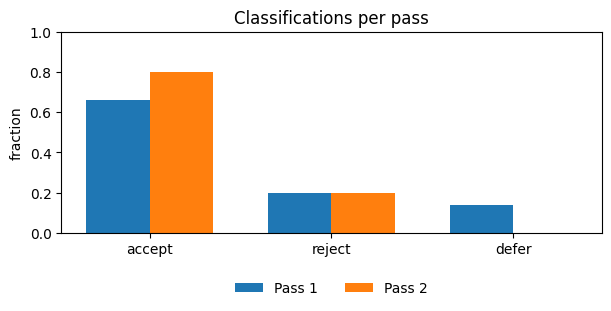

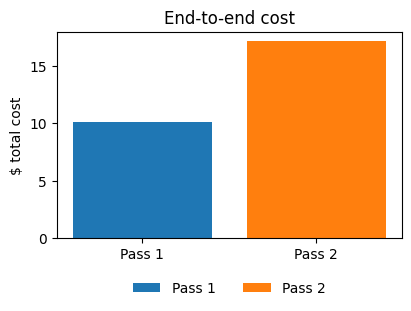

In [9]:

# ╔═════════════════════════════════════════════════════════════════╗
# ║ VISUAL SUMMARY · Pass-1  vs  Pass-2                            ║
# ╠═════════════════════════════════════════════════════════════════╣
# ║ • `plot_comparison()` draws two side-by-side figures:           ║
# ║       1.  Bar chart of accept / reject / defer share            ║
# ║           (colours stay consistent across passes).              ║
# ║       2.  Bar chart of total \$ cost for each pass.             ║
# ║ • PNGs are saved to  OUT_DIR / {kpi_bar.png, cost_bar.png}      ║
# ║   so they can be embedded in the README, plus rendered inline.  ║
# ╚═════════════════════════════════════════════════════════════════╝

plot_comparison(kpi1, kpi2, out_dir=OUT_DIR)
